<a href="https://colab.research.google.com/github/theadamsabra/Audio-Source-Separation-Undergraduate-Thesis/blob/master/notebooks/Full_Procedure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0: Package Installation and Imports

In [1]:
!pip install dsdtools

In [2]:
import dsdtools
import pandas as pd
import os
import librosa
import numpy as np
import math
import seaborn as sns
import json
from matplotlib import pyplot as plt
from google.colab import drive

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1: Exploratory Data Analysis

### 1.1: About DSD100

>The dsd100 is a dataset of 100 full lengths music tracks of different styles along with their isolated drums, bass, vocals and others stems.
> dsd100 contains two folders, a folder with a training set: "train", composed of 50 songs, and a folder with a test set: "test", composed of 50 songs. Supervised approaches should be trained on the training set and tested on both sets.
>For each file, the mixture correspond to the sum of all the signals. All signals are stereophonic and encoded at 44.1kHz.
>> [Source](https://sigsep.github.io/datasets/dsd100.html)

In [3]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/Thesis/DSD100/'
excel_sheet = '/content/drive/My Drive/Thesis/DSD100/dsd100.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
excel = pd.read_excel(excel_sheet)
excel.head()

,Name,Style,Duration
0,Actions - Devil's Words,Power Pop,3'17''
1,Actions - One Minute Smile,Power Pop,2'44''
2,Actions - South Of The Water,Power Pop,3'11''
3,Al James - Schoolboy Facination,Bubblegum Pop,3'21''
4,AM Contra - Heart Peripheral,Electronic Dance Pop,3'30''


### 1.2: Distribution Exploration

Generally, the type of style (or genre) may affect separation due to various instruments being used. However, because of how the dataset was prepared, the targets to separate are drums, bass, vocals and others. Because of this, style is simply a descriptive attribute that will not affect separation.

Instead, we will view the distribution of the length of songs in minutes to get a reasonable assesment of what to expect from the songs. The longer the song, the more data there is. This should intuitively make sense.

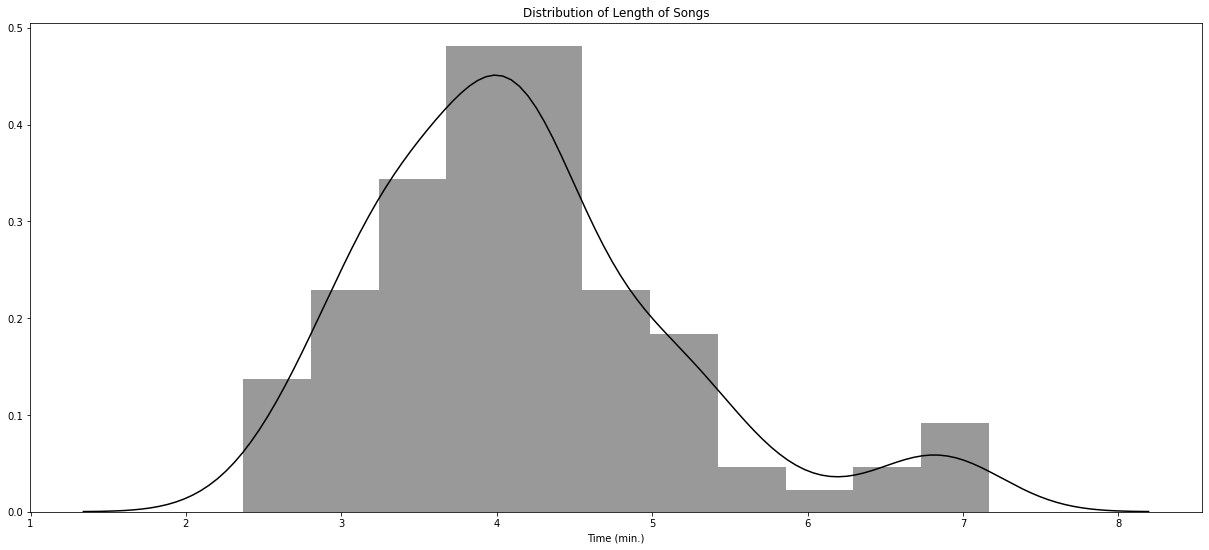

In [5]:
length = []
# Length is in a string format. 
# The minutes and seconds are parsed and converted into float
for time in excel.Duration:
  min = int(time[0])
  seconds = round(float(int(time[2:4]) / 60), 3) # Rounded to 3 decimal places
  length.append(min + seconds)

fig, ax = plt.subplots(1,1, figsize = (21,9))
plt.title('Distribution of Length of Songs')
sns.distplot(length, color='black', axlabel='Time (min.)')
plt.show()

### 1.3: Visualization of the Time Domain

In this section, we'll play around with visualisations. I will be using one track for simplicity's sake.

In [6]:
dsd = dsdtools.DB(path)
tracks = dsd.load_dsd_tracks('Dev') # Test set
audio = tracks[0].audio
sr = tracks[0].rate
vocals = tracks[0].targets['vocals'].audio
time = np.linspace(0, len(audio)/sr , num=len(audio))

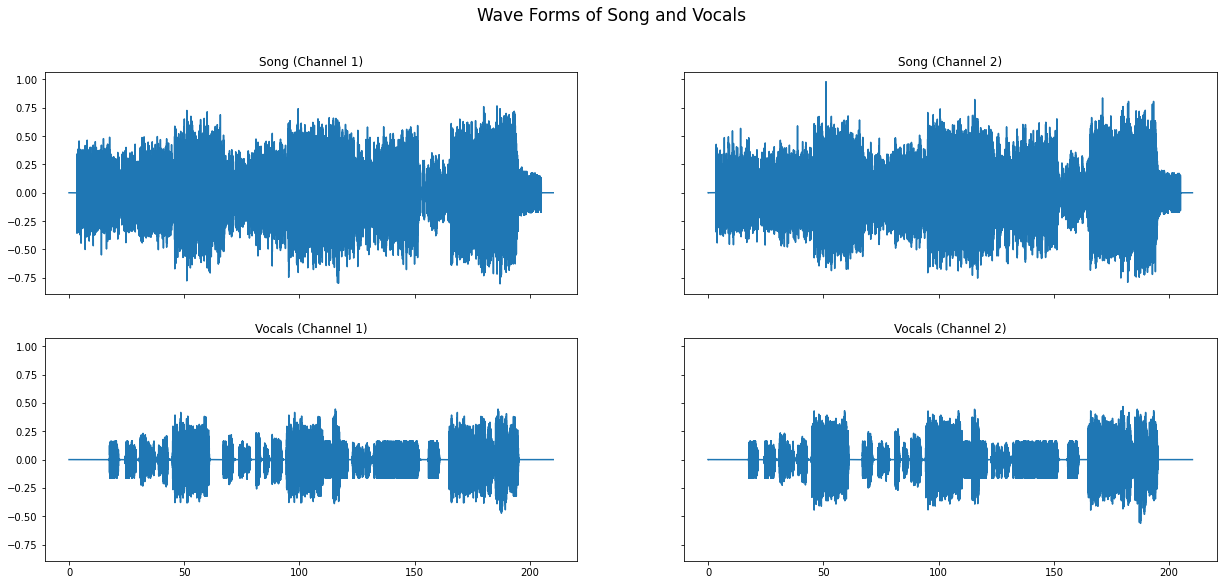

In [7]:
fig, ax = plt.subplots(2,2, figsize = (21,9), sharex=True, sharey=True)
fig.suptitle('Wave Forms of Song and Vocals', fontsize = 17)
ax[0,0].set_title('Song (Channel 1)')
ax[0,0].plot(time, audio[:, 0])
ax[0,1].set_title('Song (Channel 2)')
ax[0,1].plot(time, audio[:, 1])
ax[1,0].set_title('Vocals (Channel 1)')
ax[1,0].plot(time, vocals[:, 0])
ax[1,1].set_title('Vocals (Channel 2)')
ax[1,1].plot(time, vocals[:, 1])

Note that the songs and stems contain 2 channels - or is stereophonic. This does not make working with audio any more/less difficult to process and will actually allow us to utilize more information than a monophonic song - or 1 channel.

Think of a grayscale picture (1 layer) versus a colored picture with RGB (3 layers.)

### 1.4: Visualisation of the Frequency Domain

Now the fun stuff - audio transformations. We transform audio to view the properties of the signals in each song. Signal Processing techniques also help us visualise/paramaterize the signals at each moment in time.

For these visualizations we will be looking at the first channel of the song and vocals. However, when the model undergoes preprocessing, it will use both channels.

#### 1.4.1: Short Time Fourier Transformation

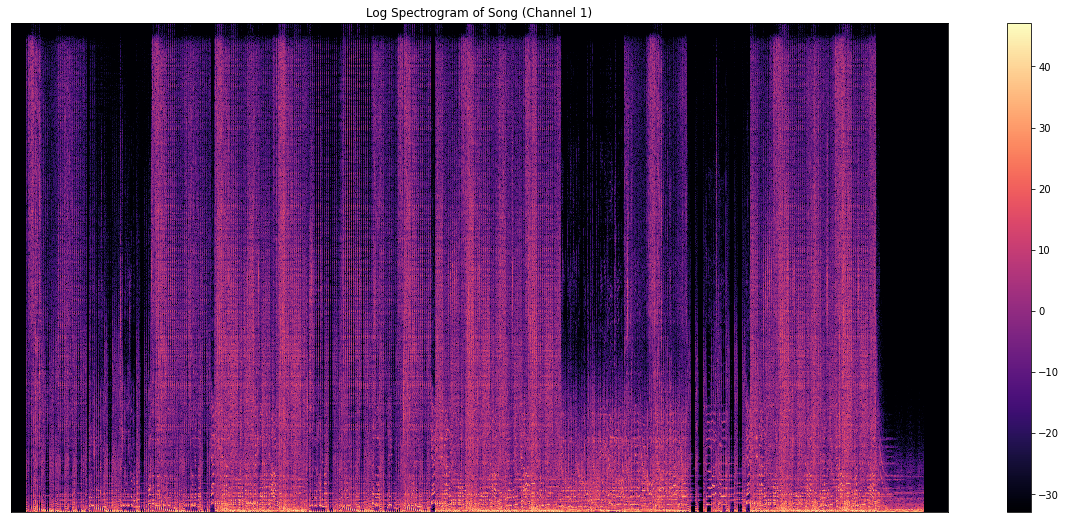

In [8]:
import librosa.display as ld
hop_length = 512
n_fft = 2048

spec_song = np.abs(librosa.core.stft(audio[:, 0], n_fft = n_fft,
                                     hop_length=hop_length))
log_spec_song = librosa.amplitude_to_db(spec_song)
fig, ax = plt.subplots(figsize = (21,9))
ax.set_title('Log Spectrogram of Song (Channel 1)')
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ld.specshow(log_spec_song, sr = sr, hop_length=hop_length, 
            cmap = 'magma')
plt.colorbar()
plt.show()

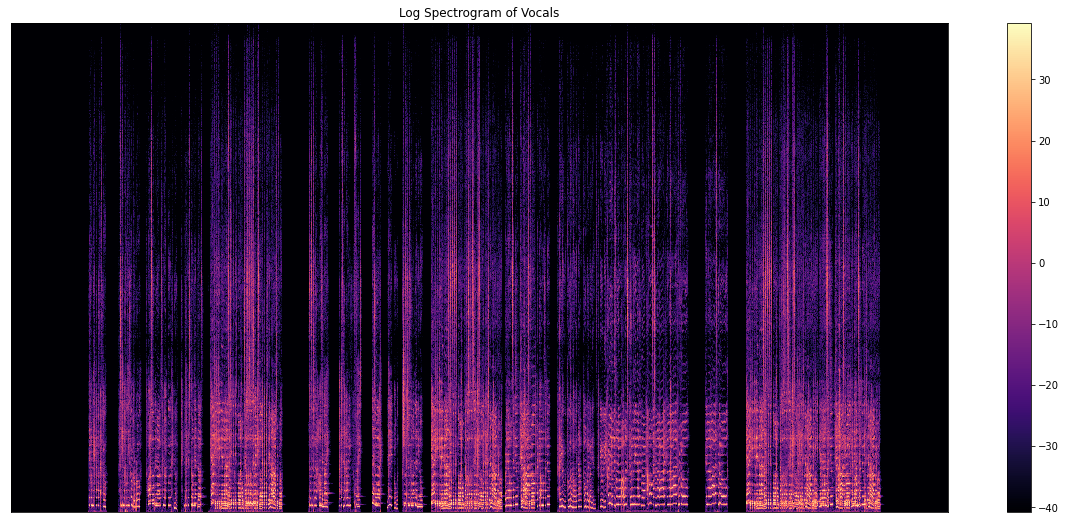

In [9]:
spec_vocals = np.abs(librosa.core.stft(vocals[:, 0], hop_length = hop_length,
                                       n_fft = n_fft))
log_spec_vocals = librosa.amplitude_to_db(spec_vocals)
fig, ax = plt.subplots(figsize = (21,9))
ax.set_title('Log Spectrogram of Vocals')
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ld.specshow(log_spec_vocals, sr = sr, hop_length=hop_length, 
            cmap = 'magma')
plt.colorbar()
plt.show()

#### 1.4.2: MFCCs

In [10]:
MFCC_audio = librosa.feature.mfcc(audio[:, 0], n_fft=n_fft, 
                                   hop_length=hop_length, sr=sr, 
                                   n_mfcc = 13)

MFCC_vocals = librosa.feature.mfcc(vocals[:, 0], n_fft=n_fft, 
                                   hop_length=hop_length, sr=sr, 
                                   n_mfcc = 13)

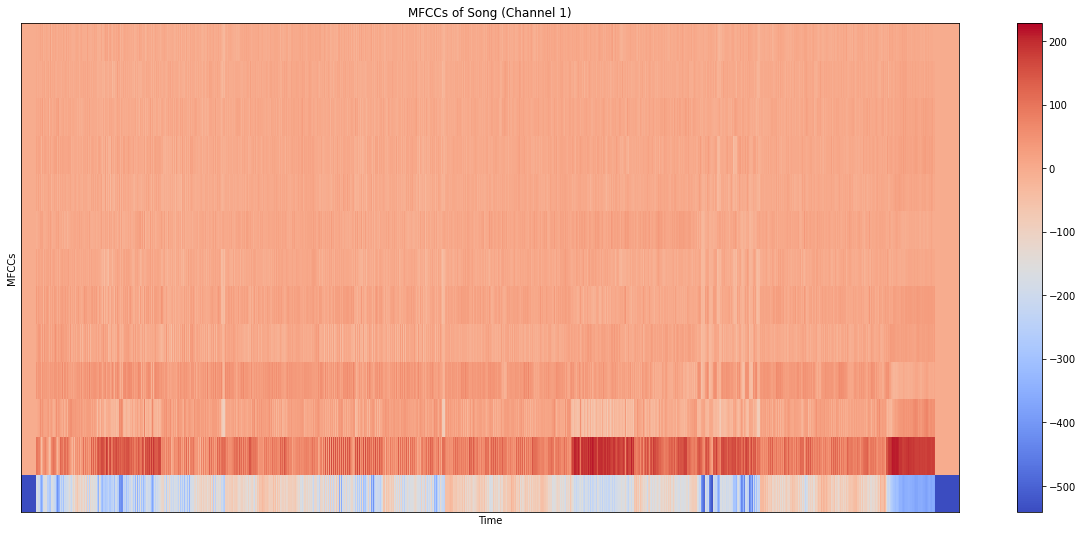

In [11]:
fig, ax = plt.subplots(figsize = (21,9))
ax.set_title('MFCCs of Song (Channel 1)')
ld.specshow(MFCC_audio, sr = sr, hop_length=hop_length)
ax.set_xlabel('Time')
ax.set_ylabel('MFCCs')
plt.colorbar()
plt.show()

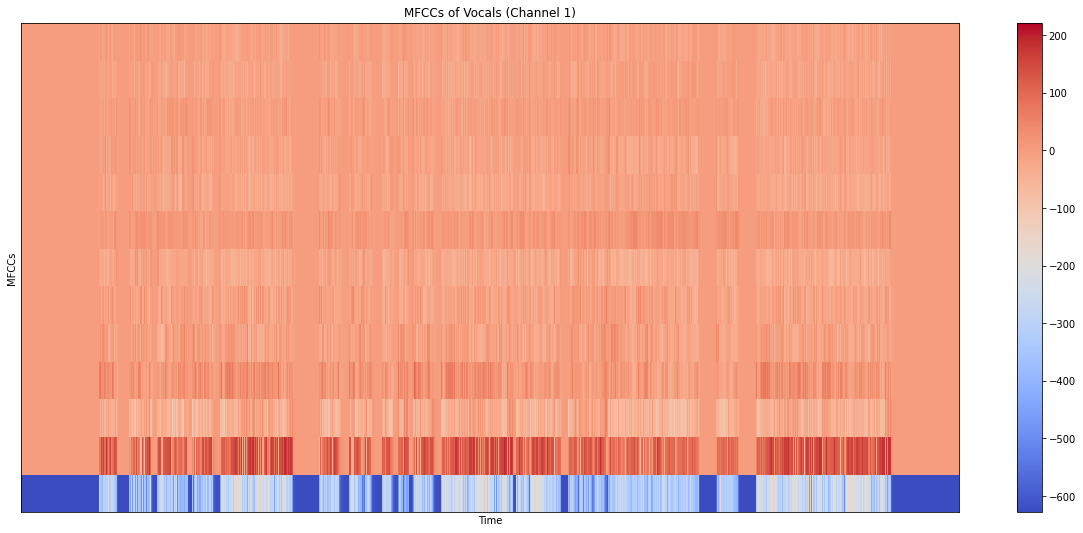

In [12]:
fig, ax = plt.subplots(figsize = (21,9))
ax.set_title('MFCCs of Vocals (Channel 1)')
ld.specshow(MFCC_vocals, sr = sr, hop_length=hop_length)
ax.set_xlabel('Time')
ax.set_ylabel('MFCCs')
plt.colorbar()
plt.show()

## 2: Data Preparation

This is where most if not all of the structure of the project will be developed. 

## Objectives for debugging Preprocessing class:

* Ensure we segment all songs into 5 second windows before performing feature extraction.

* If the length is less than 5 sec, we ignore it.

* Preprocess smoothly

* Saves a consistent array in the json file

In [27]:
'''
There are plenty of ways to structure the preprocessing the data the way the
directory is structured. I chose to use a preprocessing class to keep things
organized in one object.
'''
# Preprocessing class
class Preprocessing:
  '''
  When initializing, we set up necessary constants needed for
  preprocessing.
  '''
  def __init__(self):
    self.sr = 44100 # Samplerate
    self.n_fft = 2048 # Number of Fast Fourier Transforms we are performing
    self.n_mfcc = 13 # Number of MFCCs we are incorperating
    self.hop_length = 512 # How many points we're sliding over
    self.num_chan = 2 # Number of channels of audio in question
    self.num_segments = 100 # Number of segments we want to split all audio into
    self.path = '/content/drive/My Drive/Thesis/DSD100/' # Path of DSD100
    self.input_shape = None # None for now, will be tuple of shape
    self.data = {
        'Mixture MFCC': [],
        'Target MFCC': []
    }
    self.data_path = '/content/drive/My Drive/Thesis/data'
    self.target = 'vocals'

  def multi_mfcc(self, audio, start, end):
      '''
      The main objective of multi_mfcc is to take the MFCC of a multi-channel
      audio source by taking the MFCC of each individual channel. While this
      function can be generalized for any number of channels, I am keeping it to 
      stereophonic audio for the time being.

      This function is mainly used to improve readability of the save_mfcc function
      defined below.

      Parameters:
      -----------
      - audio: (array)
      The audio we want to find the MFCCs of.

      - start: (int)
      An integer designating the starting point where we want to slice the audio.

      - end: (int)
      An integer designating the end point where we want to slice the audio

      Returns:
      --------
      - mfcc: (array)
      The MFCC of each channel converted to a 3D array with shape of 
      (Elen, self.n_mfcc, self.num_chan)

      '''
      # Take MFCC of first channel and transpose for continuitity.
      mfcc1 = librosa.feature.mfcc(audio[start:end, 0], sr = self.sr,
                                  n_fft = self.n_fft, n_mfcc = self.n_mfcc, 
                                  hop_length = self.hop_length)
      # Take MFCC of second channel and transpose again.
      mfcc2 = librosa.feature.mfcc(audio[start:end, 1], sr = self.sr,
                                  n_fft = self.n_fft, n_mfcc = self.n_mfcc, 
                                  hop_length = self.hop_length)
      # Horizontally stack the 2 MFCCs and reshape to a 3D array.
      mfcc = np.hstack((mfcc1.T, mfcc2.T)).reshape(mfcc1.shape[0], mfcc1.shape[1], 
                                              self.num_chan)
      return mfcc

  def save_mfcc(self, mix, target):
    '''
    This function segments the mix and targets and takes its MFCC.

    Parameters:
    -----------
    mix: (array)
    The numpy array that contains the mixed song.

    target: (array)
    The numpy array that contains the target in question.
    '''
    # This is wrong. Find number of samples in segment then go from there.
    samp_per_segment = int(mix.shape[0] / self.num_segments)
    # Expected value of len of segments. We'll ignore if it's shorter
    Elen = math.ceil(samp_per_segment / self.hop_length)
    # Iterating through all segments of the song.
    for segment in range(self.num_segments):
      # Start and end of slice of song
      start = samp_per_segment * segment
      end = start + samp_per_segment
      # MFCCs of Mix:
      mix_mfcc = self.multi_mfcc(mix, start, end)
      # MFCCs of Vocals:
      tgt_mfcc = self.multi_mfcc(target, start, end)
      # If the mfcc is the desired length, we use it.
      if (len(mix_mfcc) and len(tgt_mfcc)) == Elen:
        # Append to list for storage.
        self.data['Mixtures MFCC'].append(mix_mfcc.tolist())
        self.data['Target MFCC'].append(tgt_mfcc.tolist())
  
  # Preprocess data.
  def preprocess(self, dev_test):
    '''
    This function goes to the path 

    Parameters:
    -----------
    - dev_test: (str)
    Accepts either "Dev" or "Test" as arguments. This will decide whether we are
    processing the training or test set.

    Returns:
    --------
    Processed data in data/test or data/train
    '''
    mixtures = 'Mixtures'
    source = 'Sources'
    mix_path = self.path + mixtures + '/' + dev_test
    target_path = self.path + source + '/' + dev_test

    for dirpath, dirnames, filenames in sorted(os.walk(mix_path)):
      # Ensure we're not at the root level
      if dirpath is not mix_path:
        song = dirpath.split('/')[-1]
        # Paths for files
        mix_file = os.path.join(mix_path, song, mixtures[:-1].lower() + '.wav')
        target_file = os.path.join(target_path, song, self.target + '.wav')
        # Loading in the data and performing preprocessing operations
        mix, samplerate = librosa.load(mix_file, sr = self.sr, mono = False)
        target, samplerate = librosa.load(target_file, sr = self.sr, mono = False)
        self.save_mfcc(mix, target)
    # Determine whether or not we are saving the test or train data
    if dev_test == 'Test':
      json_path = os.path.join(self.data_path, (dev_test.lower() + '.json'))
    else:
      json_path = os.path.join(self.data_path, 'train.json')
    # Save data as json file
    with open(json_path, 'w') as json_file:
      json.dump(self.data, json_file, indent = 4)